<a href="https://colab.research.google.com/github/wmerry25/CS552-HW2/blob/main/DS552_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import kagglehub
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml


#Pull data from Kaggle
path = kagglehub.dataset_download("parulpandey/palmer-archipelago-antarctica-penguin-data")

Using Colab cache for faster access to the 'palmer-archipelago-antarctica-penguin-data' dataset.


In [149]:
#Data Loading for Penguins
penguins = '/kaggle/input/palmer-archipelago-antarctica-penguin-data/penguins_size.csv'
dataIn = pd.read_csv(penguins)
filteredData = dataIn[dataIn['species'] != 'Chinstrap'].dropna()

#Class Labels
filteredData['species_label'] = filteredData['species'].astype('category').cat.codes
filteredData['sex_label'] = filteredData['sex'].astype('category').cat.codes
filteredData['island_label'] = filteredData['island'].astype('category').cat.codes

#Test Train Split
x = filteredData[['island_label','culmen_length_mm', 'culmen_depth_mm','flipper_length_mm', 'body_mass_g', 'sex_label']]
y = filteredData['species_label']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,shuffle=True,random_state=3)

In [150]:
#Bayes
nb = MultinomialNB()
nb.fit(x_train, y_train)
y_pred_NBTest = nb.predict(x_test)
y_pred_NBTrain = nb.predict(x_train)
y_prob_NBTest = nb.predict_proba(x_test)[:,1]

#Regression
lr = LogisticRegression(max_iter = 300)
lr.fit(x_train,y_train)
y_pred_LRTest= lr.predict(x_test)
y_pred_LRTrain = lr.predict(x_train)
y_prob_LRTest = lr.predict_proba(x_test)[:,1]


In [151]:
#Accuracy
NB_train_accuracy = accuracy_score(y_train,y_pred_NBTrain)
NB_test_accuracy = accuracy_score(y_test,y_pred_NBTest)
LR_test_accuracy = lr.score(x_test,y_test)
LR_train_accuracy = lr.score(x_train, y_train)
print("*************** Accuracy ***************")
print(f"Naive Bayes Train Accuracy: {NB_train_accuracy}")
print(f"Naive Bayes Test Accuracy: {NB_test_accuracy}")
print(f"Logistic Regression Train Accuracy: {LR_train_accuracy}")
print(f"Logistic Regression Test Accuracy: {LR_test_accuracy}")


*************** Accuracy ***************
Naive Bayes Train Accuracy: 0.9528301886792453
Naive Bayes Test Accuracy: 0.9259259259259259
Logistic Regression Train Accuracy: 1.0
Logistic Regression Test Accuracy: 1.0


**Question 1**
*Compare the performance of these models in terms of accuracy to determine which model better
distinguishes between the two penguin species. Provide a brief explanation of your findings.*
\
The above code block calculates the test and training accuracy for the Naive Bayes and Logistic Regression classification models. For the training and test split, I used an 80% training and 20% test split. The Logistic Regression model performs better than the Naive Bayes as expected. Discriminative models are typically more accurate with classification problems as discriminator models directly determine the decision boundary between classes, generative models learn the joint distribution making them more useful for creating sythetic data or data generation tasks in general. When dealing with classes with similar feature, the discriminator performs better.

In [152]:
#AUC
NB_train_auc = roc_auc_score(y_train,y_pred_NBTrain)
NB_test_auc = roc_auc_score(y_test,y_pred_NBTest)
LR_test_auc = roc_auc_score(y_test,y_pred_LRTest)
LR_train_auc = roc_auc_score(y_train,y_pred_LRTrain)
print("******* Area Under The ROC Curve *******")
print(f"Naive Bayes Train AUC: {NB_train_auc}")
print(f"Naive Bayes Test AUC: {NB_test_auc}")
print(f"Logistic Regression Train AUC: {LR_train_auc}")
print(f"Logistic Regression Test AUC: {LR_test_auc}")

******* Area Under The ROC Curve *******
Naive Bayes Train AUC: 0.9538750335210513
Naive Bayes Test AUC: 0.9307359307359306
Logistic Regression Train AUC: 1.0
Logistic Regression Test AUC: 1.0


**Question 2**
*Calculate the AUC for both Naive Bayes and Logistic Regression on the training and test datasets. Interpret the AUC values for both models to assess how effectively each model discriminates between
the two penguin species. Provide insights into which model is more effective based on the AUC metric.*\
The block above calculates the area under the ROC curve for Naive Bayes and Logistic Regression training and test data sets. Similar to the accuracy, the Logistic Regression performs better on the AUC for the same reasons as above.


In [153]:
bayes_probabilities = pd.DataFrame({'Prob': y_prob_NBTest, 'Class Label': y_test})
bayes_probabilities = bayes_probabilities.sort_values('Prob',ascending=False)
bayes_probabilities['decile'] = pd.qcut(bayes_probabilities['Prob'],10,labels=False)
bayes_probabilities['decile'] = 10 - bayes_probabilities['decile']
total_pos = bayes_probabilities['Class Label'].sum()
bayes_mean = bayes_probabilities['Class Label'].mean()
bayes_lift = (bayes_probabilities.groupby('decile')['Class Label'].mean().reset_index())
bayes_gain = (bayes_probabilities.groupby('decile')['Class Label'].sum().reset_index())
bayes_lift.rename(columns={'Class Label':'Avg Positives in Decile'}, inplace = True)
bayes_gain.rename(columns={'Class Label':'Positives in Decile'}, inplace = True)
bayes_gain['Cumulative Sum'] = bayes_gain['Positives in Decile'].cumsum()
bayes_lift['Lift'] = bayes_lift['Avg Positives in Decile']/bayes_mean
bayes_gain['Gain'] = bayes_gain['Cumulative Sum']/total_pos

regression_probabilities = pd.DataFrame({'Prob': y_prob_LRTest, 'Class Label': y_test})
regression_probabilities = regression_probabilities.sort_values('Prob',ascending=False)
regression_probabilities['decile'] = pd.qcut(regression_probabilities['Prob'],10,labels=False)
regression_probabilities['decile'] = 10 - regression_probabilities['decile']
total_pos = regression_probabilities['Class Label'].sum()
regression_mean = regression_probabilities['Class Label'].mean()
regression_lift = (regression_probabilities.groupby('decile')['Class Label'].mean().reset_index())
regression_gain = (regression_probabilities.groupby('decile')['Class Label'].sum().reset_index())
regression_lift.rename(columns={'Class Label':'Avg Positives in Decile'}, inplace = True)
regression_gain.rename(columns={'Class Label':'Positives in Decile'}, inplace = True)
regression_gain['Cumulative Sum'] = regression_gain['Positives in Decile'].cumsum()
regression_lift['Lift'] = regression_lift['Avg Positives in Decile']/regression_mean
regression_gain['Gain'] = regression_gain['Cumulative Sum']/total_pos

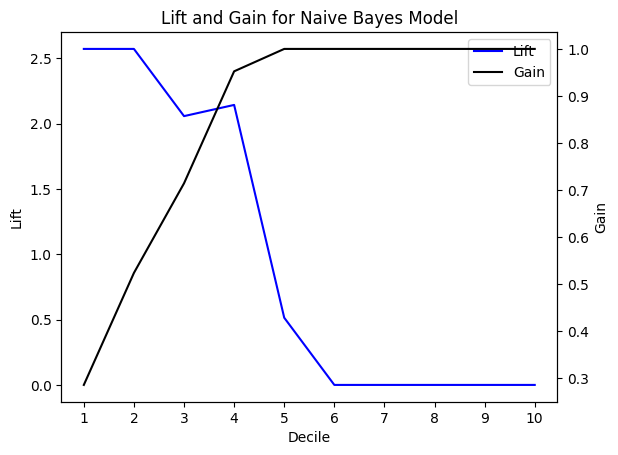

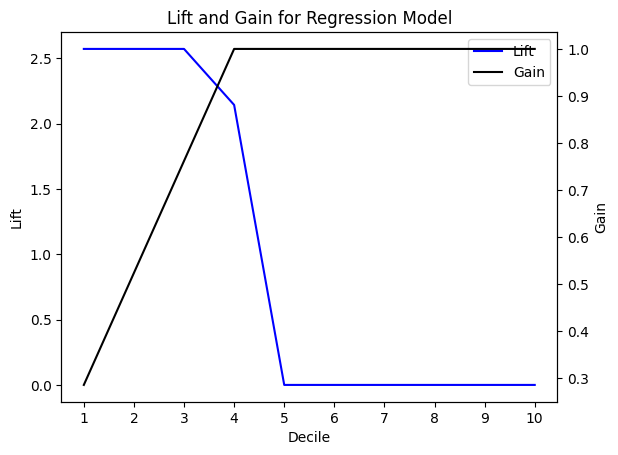

In [154]:
#Bayes
fig, ax_lift = plt.subplots()
lift_plot = ax_lift.plot(bayes_lift['decile'],bayes_lift['Lift'],'b')
ax_lift.set_xlabel("Decile")
ax_lift.set_ylabel("Lift")
ax_gain=ax_lift.twinx()
gain_plot = ax_gain.plot(bayes_gain['decile'],bayes_gain['Gain'],'k')
ax_gain.set_ylabel("Gain")

plots = lift_plot + gain_plot
labels = ['Lift', 'Gain']

ax_lift.legend(plots, labels)
plt.title("Lift and Gain for Naive Bayes Model")
plt.xticks(range(1,11))
plt.show()

#regression
fig, ax_lift = plt.subplots()
lift_plot = ax_lift.plot(regression_lift['decile'],regression_lift['Lift'],'b')
ax_lift.set_xlabel("Decile")
ax_lift.set_ylabel("Lift")
ax_gain=ax_lift.twinx()
gain_plot = ax_gain.plot(regression_gain['decile'],regression_gain['Gain'],'k')
ax_gain.set_ylabel("Gain")

plots = lift_plot + gain_plot
labels = ['Lift', 'Gain']

ax_lift.legend(plots, labels)
plt.title("Lift and Gain for Regression Model")
plt.xticks(range(1,11))
plt.show()

**Question 3**
*Generate Lift and Gain charts for both Naive Bayes and Logistic Regression using 10 deciles. Use a dual y-axis plot with deciles on the x-axis, and Lift and Gain on the y-axis. Evaluate the Lift and Gain charts to understand how well each model ranks the predicted probabilities and how effective each model is in prioritizing the classification of the two species.*\
For both of the above graphs, they were generated using the test datasets. The gain performs slightly better on the regression model as the graph reaches its peach slightly earlier in decile 4 rather than decile 5. The same applies for lift. The regression model reaches 0 quicker at decile 5 as compared to decile 6 for the bayes model. This is again expected due to the regression model's strength in classification tasks over a generative model.

**Question 4**
*Based on the results from accuracy, AUC, and Lift/Gain charts, compare the overall performance of Naive Bayes and Logistic Regression models. Discuss which model performs better in classifying the two penguin species and provide reasons for your conclusion.*
Overall, the Logistic Regression model performs better in all tests over the Naive Bayes. This can be seen in the acuracy test, where the Logistic Regression model was 100% accurate on both the training and test sets compared to 95.2% and 92.6% for the Naive Bayes training and test accuracy respectively. The strong performance of the Logistic Regression is also evident in the area under the Receiver-operating characteristic curve where the Logistic Regression model had an AUC of 1.0 for both training and test sets while the Naive Bayes had an AUC of 0.954 and 0.931 for train and test respectively. Finally, the list and gain charts showcased the stronger performance of the Logistic Regression model where both gain and lift reached their ideal states in earlier deciles than the Naive Bayes model.

In [3]:
#Data Loading for MNIST
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True,random_state=3)

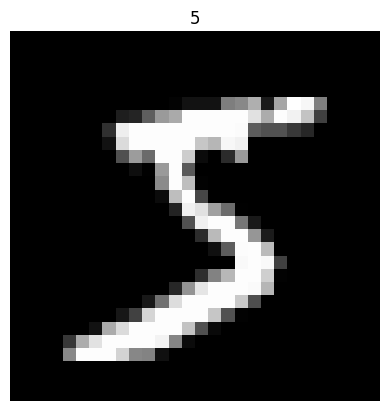

In [4]:
#Vizualize MNIST Data
plt.imshow(X[0].reshape(28, 28),cmap="gray")
plt.axis("off")
plt.title(y[0])
plt.show()

In [5]:
#Bayes
nb = MultinomialNB()
nb.fit(x_train, y_train)
y_pred_NBTest = nb.predict(x_test)
y_pred_NBTrain = nb.predict(x_train)
y_prob_NBTest = nb.predict_proba(x_test)
y_prob_NBTrain = nb.predict_proba(x_train)

#Regression
lr = LogisticRegression(max_iter = 500)
lr.fit(x_train,y_train)
y_pred_LRTest= lr.predict(x_test)
y_pred_LRTrain = lr.predict(x_train)
y_prob_LRTest = lr.predict_proba(x_test)
y_prob_LRTrain = lr.predict_proba(x_train)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [6]:
#Accuracy
NB_train_accuracy = accuracy_score(y_train,y_pred_NBTrain)
NB_test_accuracy = accuracy_score(y_test,y_pred_NBTest)
LR_test_accuracy = lr.score(x_test,y_test)
LR_train_accuracy = lr.score(x_train, y_train)
print("*************** Accuracy ***************")
print(f"Naive Bayes Train Accuracy: {NB_train_accuracy}")
print(f"Naive Bayes Test Accuracy: {NB_test_accuracy}")
print(f"Logistic Regression Train Accuracy: {LR_train_accuracy}")
print(f"Logistic Regression Test Accuracy: {LR_test_accuracy}")

*************** Accuracy ***************
Naive Bayes Train Accuracy: 0.8268035714285714
Naive Bayes Test Accuracy: 0.831
Logistic Regression Train Accuracy: 0.9412857142857143
Logistic Regression Test Accuracy: 0.9201428571428572


In [7]:
NB_train_auc = roc_auc_score(y_train,y_prob_NBTrain, multi_class='ovr')
NB_test_auc = roc_auc_score(y_test,y_prob_NBTest,  multi_class='ovr')
LR_test_auc = roc_auc_score(y_test,y_prob_LRTest,  multi_class='ovr')
LR_train_auc = roc_auc_score(y_train,y_prob_LRTrain,  multi_class='ovr')
print("******* Area Under The ROC Curve *******")
print(f"Naive Bayes Train AUC: {NB_train_auc}")
print(f"Naive Bayes Test AUC: {NB_test_auc}")
print(f"Logistic Regression Train AUC: {LR_train_auc}")
print(f"Logistic Regression Test AUC: {LR_test_auc}")

******* Area Under The ROC Curve *******
Naive Bayes Train AUC: 0.9180629327460567
Naive Bayes Test AUC: 0.920090903530871
Logistic Regression Train AUC: 0.9962144686302178
Logistic Regression Test AUC: 0.9921300402502503


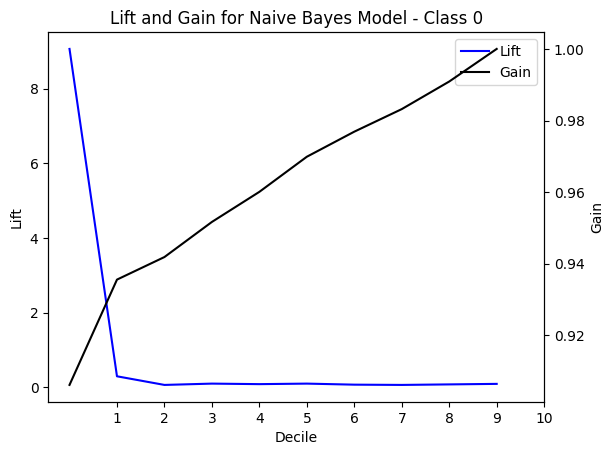

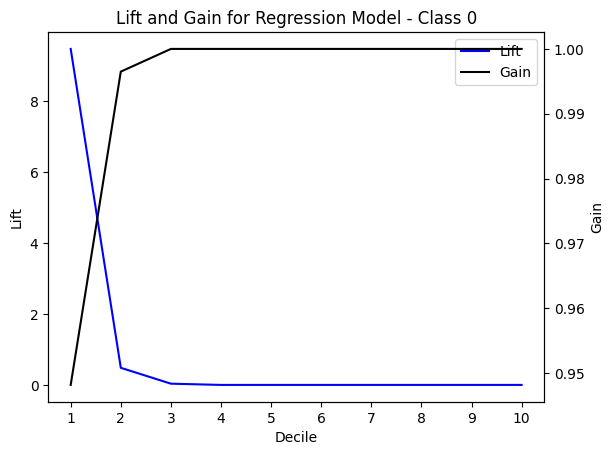

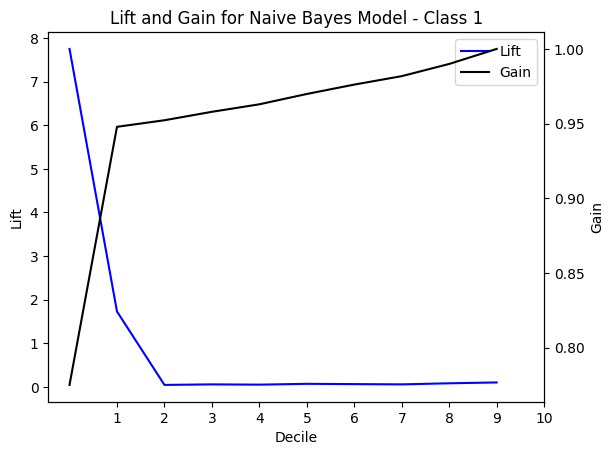

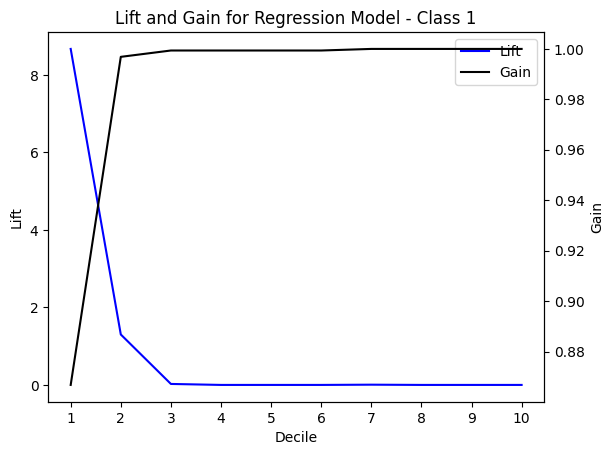

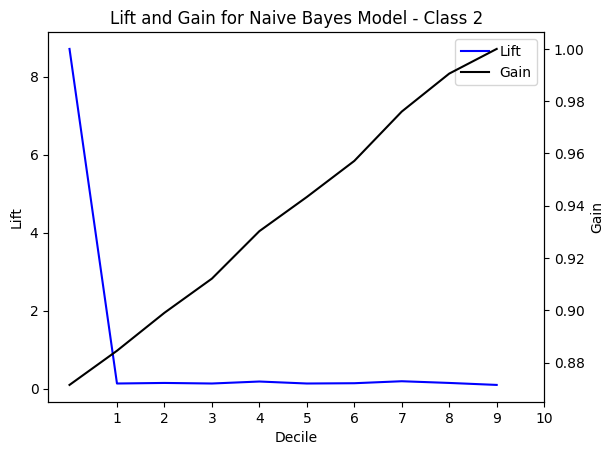

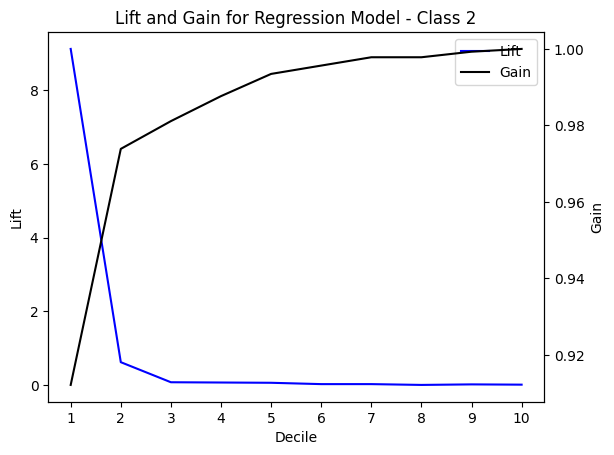

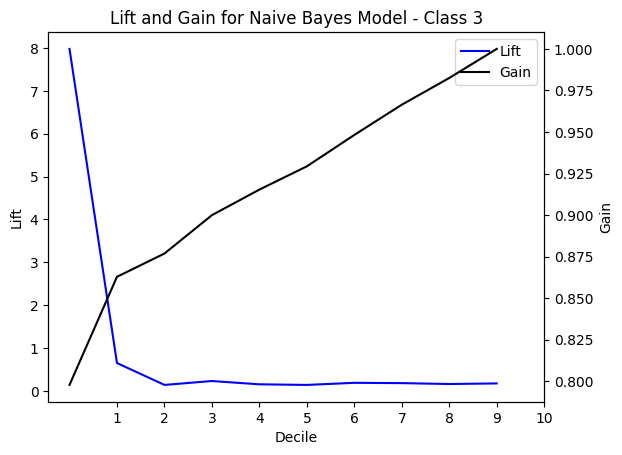

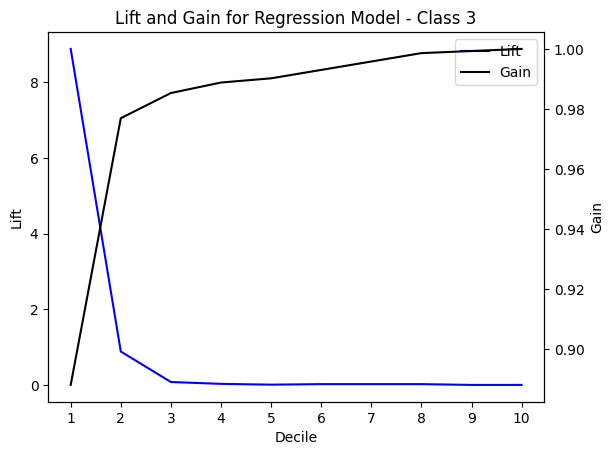

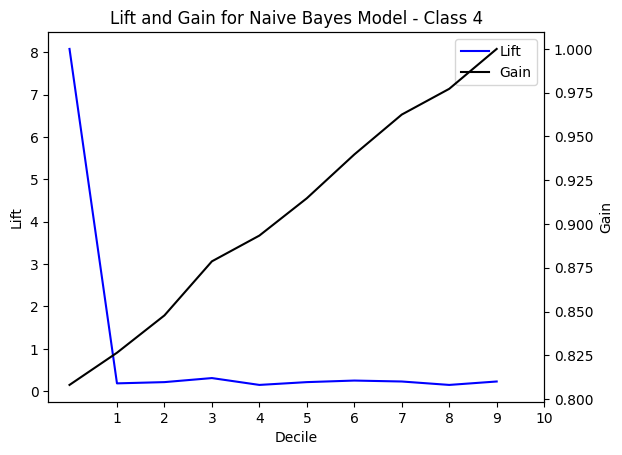

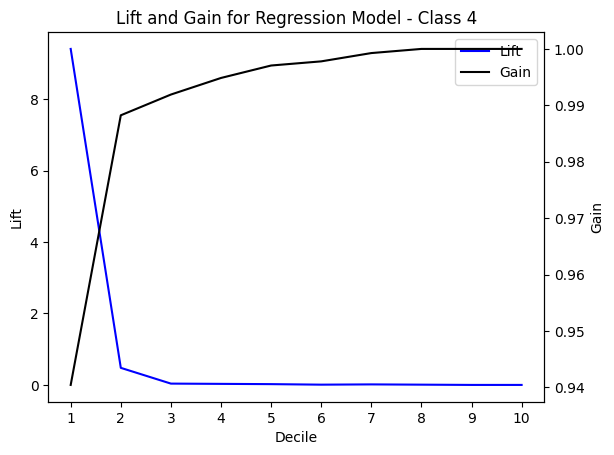

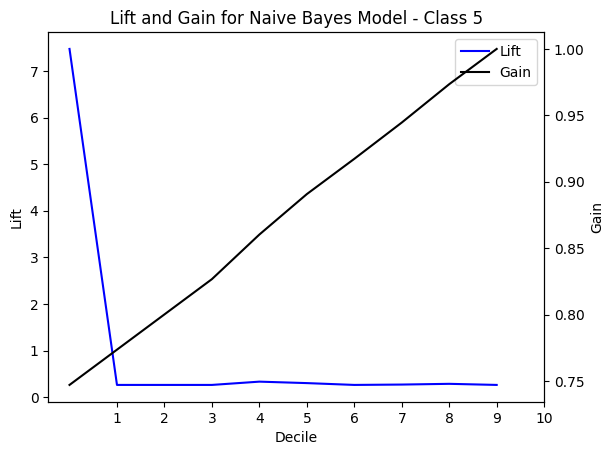

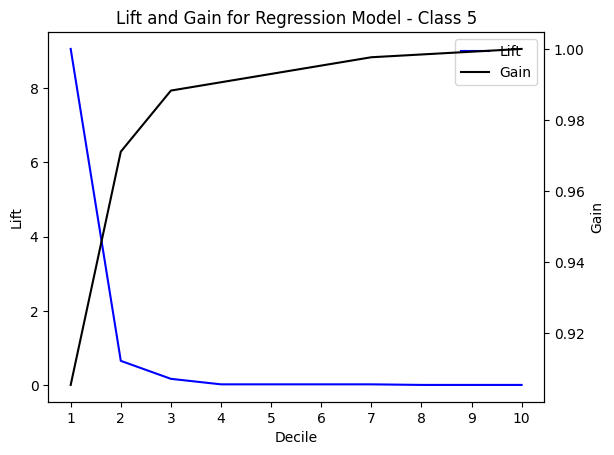

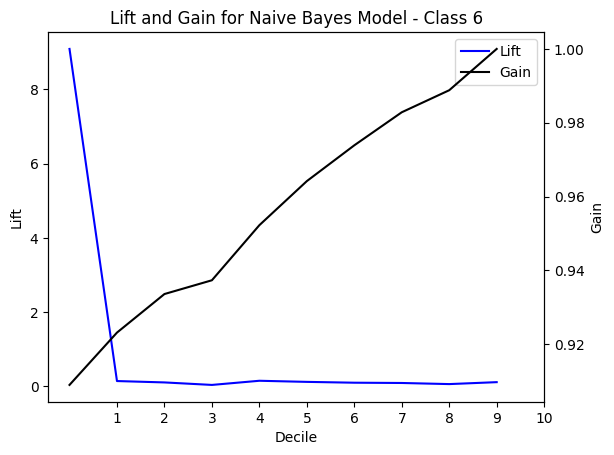

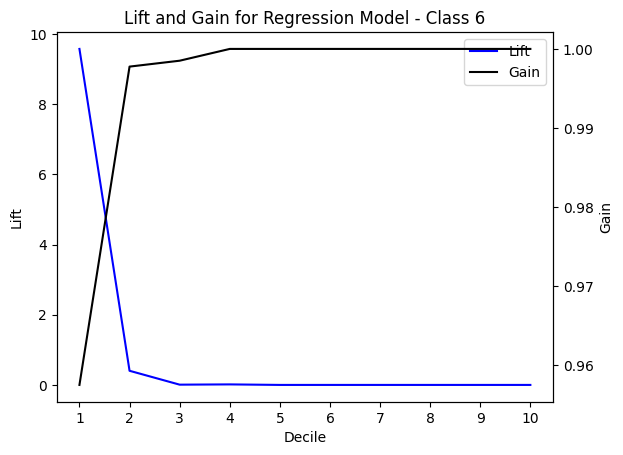

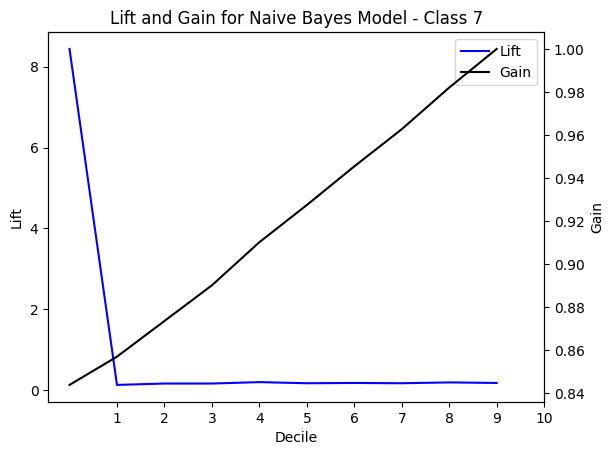

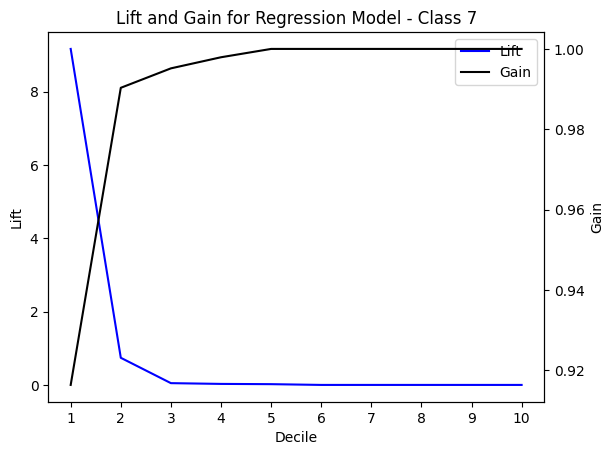

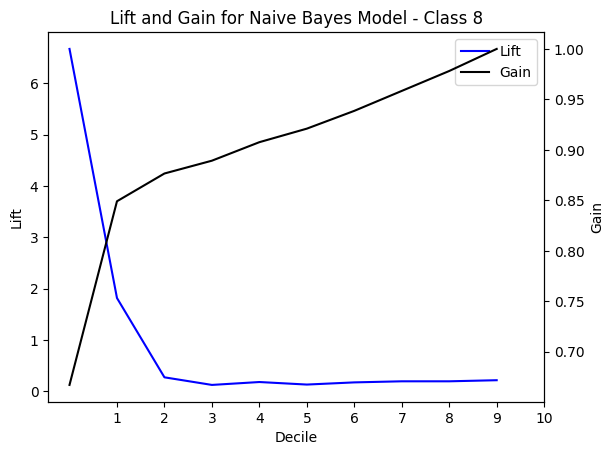

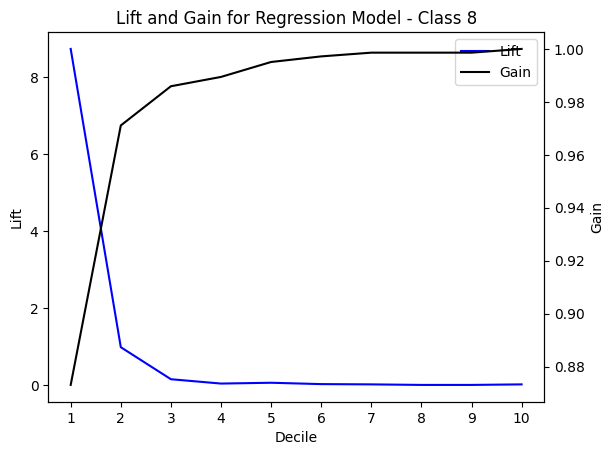

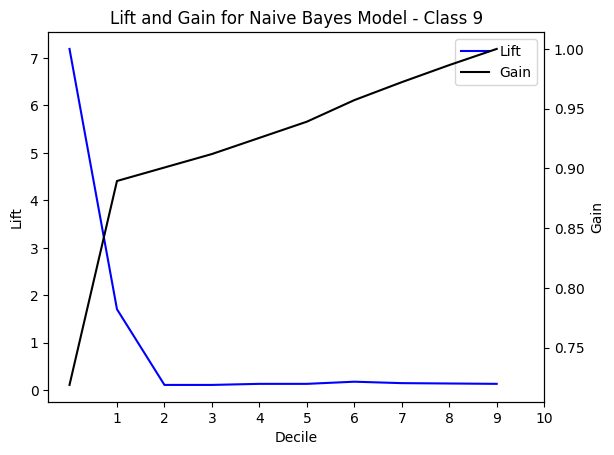

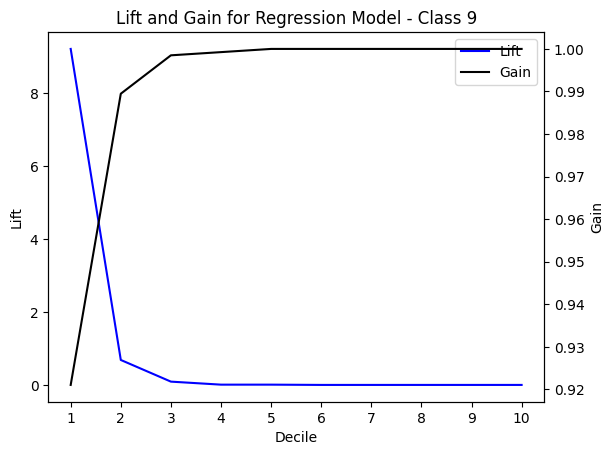

In [70]:
for selected_class in range(10):
  bayes_probabilities = pd.DataFrame({'Prob': y_prob_NBTest[:,selected_class], 'Class Label': (y_test.astype(int) == selected_class).astype(int)})
  bayes_probabilities = bayes_probabilities.sort_values('Prob',ascending=False)
  bayes_probabilities['decile'] = bayes_probabilities['Prob'].rank(method='first',ascending=False).apply(lambda x: int(10*(x-1)/len(bayes_probabilities)))
  total_pos = bayes_probabilities['Class Label'].sum()
  bayes_mean = bayes_probabilities['Class Label'].mean()
  bayes_lift = (bayes_probabilities.groupby('decile')['Class Label'].mean().reset_index())
  bayes_gain = (bayes_probabilities.groupby('decile')['Class Label'].sum().reset_index())
  bayes_lift.rename(columns={'Class Label':'Avg Positives in Decile'}, inplace = True)
  bayes_gain.rename(columns={'Class Label':'Positives in Decile'}, inplace = True)
  bayes_gain['Cumulative Sum'] = bayes_gain['Positives in Decile'].cumsum()
  bayes_lift['Lift'] = bayes_lift['Avg Positives in Decile']/bayes_mean
  bayes_gain['Gain'] = bayes_gain['Cumulative Sum']/total_pos

  regression_probabilities = pd.DataFrame({'Prob': y_prob_LRTest[:,selected_class], 'Class Label': (y_test.astype(int) == selected_class).astype(int)})
  regression_probabilities = regression_probabilities.sort_values('Prob',ascending=False)
  regression_probabilities['decile'] = pd.qcut(regression_probabilities['Prob'],10,labels=False)
  regression_probabilities['decile'] = 10 - regression_probabilities['decile']
  total_pos = regression_probabilities['Class Label'].sum()
  regression_mean = regression_probabilities['Class Label'].mean()
  regression_lift = (regression_probabilities.groupby('decile')['Class Label'].mean().reset_index())
  regression_gain = (regression_probabilities.groupby('decile')['Class Label'].sum().reset_index())
  regression_lift.rename(columns={'Class Label':'Avg Positives in Decile'}, inplace = True)
  regression_gain.rename(columns={'Class Label':'Positives in Decile'}, inplace = True)
  regression_gain['Cumulative Sum'] = regression_gain['Positives in Decile'].cumsum()
  regression_lift['Lift'] = regression_lift['Avg Positives in Decile']/regression_mean
  regression_gain['Gain'] = regression_gain['Cumulative Sum']/total_pos


  #Bayes
  fig, ax_lift = plt.subplots()
  lift_plot = ax_lift.plot(bayes_lift['decile'],bayes_lift['Lift'],'b')
  ax_lift.set_xlabel("Decile")
  ax_lift.set_ylabel("Lift")
  ax_gain=ax_lift.twinx()
  gain_plot = ax_gain.plot(bayes_gain['decile'],bayes_gain['Gain'],'k')
  ax_gain.set_ylabel("Gain")

  plots = lift_plot + gain_plot
  labels = ['Lift', 'Gain']

  ax_lift.legend(plots, labels)
  plt.title(f"Lift and Gain for Naive Bayes Model - Class {selected_class}")
  plt.xticks(range(1,11))
  plt.show()

  #regression
  fig, ax_lift = plt.subplots()
  lift_plot = ax_lift.plot(regression_lift['decile'],regression_lift['Lift'],'b')
  ax_lift.set_xlabel("Decile")
  ax_lift.set_ylabel("Lift")
  ax_gain=ax_lift.twinx()
  gain_plot = ax_gain.plot(regression_gain['decile'],regression_gain['Gain'],'k')
  ax_gain.set_ylabel("Gain")

  plots = lift_plot + gain_plot
  labels = ['Lift', 'Gain']

  ax_lift.legend(plots, labels)
  plt.title(f"Lift and Gain for Regression Model - Class {selected_class}")
  plt.xticks(range(1,11))
  plt.show()


**Question 5**
*Extend your analysis by applying both Naive Bayes and Logistic Regression to a more complex dataset, such as MNIST (handwritten digits). Compare how the performance of generative models (e.g., Naive Bayes) and discriminative models (e.g., Logistic Regression) differs when dealing with image data (MNIST) compared to the two-species penguin dataset. Discuss the differences in performance and behavior across these datasets.*\
In the above sections, I extended my above code to use the MNIST handwritten digits dataset, thus changing the binary classification problem to a multi-class classification problem. Following this, I performed accuracy and AUC testing for both the Naive Bayes and Logistical Regression models. AS expected the Logistical Regression model out-performed the Naive Bayes. When comparing the penguins (binary) and MNIST (multi-class) classifications, both models performed better on the binary classification problem. With respect to the training data or both, the Naive Bayes was 9.5% more accurate on the binary problem as compared to the multi-class problem and the Logistic Regression model was 8.0% more accurate for the same comparison. A similar comparison can be made for the area under the ROC curve with the AUC for the penguins dataset being stronger than that of the MNIST.